Importing required Libraries

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

In [3]:
from google.colab import files
uploaded = files.upload()

Saving Fake.csv to Fake.csv
Saving True.csv to True.csv


In [4]:
import io

Reading the data files and adding labels for Fake(1) and True(0) news

In [5]:
fake_news = pd.read_csv(io.StringIO(uploaded['Fake.csv'].decode('utf-8')))
true_news = pd.read_csv(io.StringIO(uploaded['True.csv'].decode('utf-8')))

In [6]:
fake_news["fake"]=1
true_news["fake"]=0

In [7]:
all_news = pd.concat([true_news,fake_news],ignore_index=True)

In [8]:
all_news_reduced = all_news[["text","fake"]]

Stratified sampling (to have same distribution of fake news)

Sampling the data set into train, test and validation splits , this will ensure that all the splits have same disctribution of fake news

In [9]:
from sklearn.model_selection import StratifiedShuffleSplit

In [10]:
split = StratifiedShuffleSplit(n_splits=1,test_size=0.2,random_state=42)
for train_index,test_index in split.split(all_news_reduced,all_news_reduced["fake"]):
    train_valid_set = all_news_reduced.loc[train_index]
    test_set = all_news_reduced.loc[test_index]

In [11]:
split_2 = StratifiedShuffleSplit(n_splits=1,test_size=0.1,random_state=42)
for train_index,valid_index in split.split(train_valid_set,train_valid_set["fake"]):
    train_set = train_valid_set.iloc[train_index]
    valid_set = train_valid_set.iloc[valid_index]

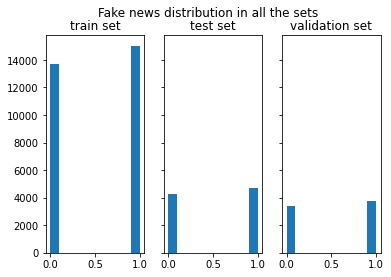

In [12]:
fig,(train,test,valid) = plt.subplots(1,3,sharey=True)
fig.suptitle('Fake news distribution in all the sets')
train.hist(train_set["fake"])
train.set_title('train set')
test.hist(test_set["fake"])
test.set_title("test set")
valid.hist(valid_set["fake"])
valid.set_title("validation set")
plt.show()


Taking out labels

In [13]:
x_train = train_set["text"]
y_train = train_set["fake"]

x_test = test_set["text"]
y_test = test_set["fake"]

x_valid = valid_set["text"]
y_valid = valid_set["fake"]

DATA PROCESSING

In [14]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [15]:
max_words = 1000
replace_list = {r"i'm": 'i am',
                r"'re": ' are',
                r"let’s": 'let us',
                r"'s":  ' is',
                r"'ve": ' have',
                r"can't": 'can not',
                r"cannot": 'can not',
                r"shan’t": 'shall not',
                r"n't": ' not',
                r"'d": ' would',
                r"'ll": ' will',
                r"'scuse": 'excuse',
                ',': ' ,',
                '.': ' .',
                '!': ' !',
                '?': ' ?',
                '\s+': ' '}

Defining functions to clean and process the text. For cleaning, we are converting the text into lower case and replacing the words as per the "replace_list defined above". For Processing, we defined a function, process_text, which is tokenizing the text and adding the padding to the text, to keep the length of text limited to 50 words.

In [16]:
def clean_text(text):
    text = text.lower()
    for s in replace_list:
        text = text.replace(s, replace_list[s])
    text = ' '.join(text.split())
    return text

def process_text(text,tokenizer):
    text = tokenizer.texts_to_sequences(text)
    text = pad_sequences(text, maxlen = 50)
    return text

Next, We applying cleaning and processing functions to our samples (train test and valid)



In [17]:
x_train = x_train.apply(lambda p: clean_text(p))

In [18]:
tokenizer = Tokenizer(
    num_words = max_words,
    filters = '"#$%&()*+-/:;<=>@[\]^_`{|}~'
    )
tokenizer.fit_on_texts(x_train)

In [19]:
x_train = process_text(x_train,tokenizer)

In [20]:
x_test = x_test.apply(lambda p: clean_text(p))

In [21]:
x_test = process_text(x_test,tokenizer)

In [22]:
x_valid = x_valid.apply(lambda p: clean_text(p))

In [23]:
x_valid = process_text(x_valid,tokenizer)

FITTING THE MODEL

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, GlobalMaxPooling1D, SpatialDropout1D

In [25]:
model_lstm = Sequential()
model_lstm.add(Embedding(input_dim = 1000, output_dim = 256, input_length = 50))
model_lstm.add(SpatialDropout1D(0.3))
model_lstm.add(LSTM(256, dropout = 0.3, recurrent_dropout = 0.3))
model_lstm.add(Dense(256, activation = 'relu'))
model_lstm.add(Dropout(0.3))
model_lstm.add(Dense(1, activation = 'sigmoid'))
model_lstm.compile(
    loss='categorical_crossentropy',
    optimizer='Adam',
    metrics=['accuracy']
)

In [27]:
history = model_lstm.fit(
    x_train,
    y_train,
    epochs = 8,
    batch_size = 512,
    validation_data=(x_valid,y_valid)
)

Epoch 1/8
57/57 [==============================] - 134s 2s/step - loss: 0.0000e+00 - accuracy: 0.4770 - val_loss: 0.0000e+00 - val_accuracy: 0.4770
Epoch 2/8
57/57 [==============================] - 133s 2s/step - loss: 0.0000e+00 - accuracy: 0.4770 - val_loss: 0.0000e+00 - val_accuracy: 0.4770
Epoch 3/8
57/57 [==============================] - 134s 2s/step - loss: 0.0000e+00 - accuracy: 0.4770 - val_loss: 0.0000e+00 - val_accuracy: 0.4770
Epoch 4/8
57/57 [==============================] - 133s 2s/step - loss: 0.0000e+00 - accuracy: 0.4770 - val_loss: 0.0000e+00 - val_accuracy: 0.4770
Epoch 5/8
57/57 [==============================] - 134s 2s/step - loss: 0.0000e+00 - accuracy: 0.4770 - val_loss: 0.0000e+00 - val_accuracy: 0.4770
Epoch 6/8
57/57 [==============================] - 132s 2s/step - loss: 0.0000e+00 - accuracy: 0.4770 - val_loss: 0.0000e+00 - val_accuracy: 0.4770
Epoch 7/8
57/57 [==============================] - 132s 2s/step - loss: 0.0000e+00 - accuracy: 0.4770 - val_loss

In [28]:
 # serialize model to JSON
model_json = model_lstm.to_json()
with open("rnn_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model_lstm.save_weights("rnn_model.h5")
print("Saved model to disk")

Saved model to disk


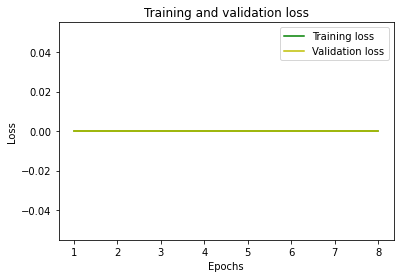

In [29]:
plt.clf()
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'y', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

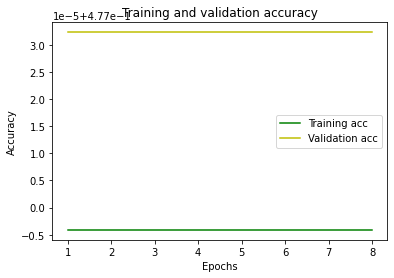

In [30]:
plt.clf()
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'y', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

BUILDING MODEL USING MASKING

In [25]:
embed_size = 128
K = keras.backend
inputs = keras.layers.Input(shape=[None])
mask = keras.layers.Lambda(lambda inputs: K.not_equal(inputs,0))(inputs)
z= keras.layers.Embedding(max_words,embed_size)(inputs)
z= keras.layers.GRU(128,return_sequences=True)(z,mask=mask)
z= keras.layers.GRU(128)(z,mask=mask)
outputs= keras.layers.Dense(1,activation="sigmoid")(z)
model = keras.Model(inputs=[inputs],outputs=[outputs])
model.compile(loss="binary_crossentropy",optimizer="adam",metrics=["accuracy"])

In [26]:
history_2 = model.fit(x_train,
    y_train,
    epochs=4,validation_data=(x_valid,y_valid)) 

Epoch 1/4
898/898 [==============================] - 133s 139ms/step - loss: 0.1297 - accuracy: 0.9558 - val_loss: 0.0917 - val_accuracy: 0.9701
Epoch 2/4
898/898 [==============================] - 123s 137ms/step - loss: 0.0793 - accuracy: 0.9742 - val_loss: 0.0874 - val_accuracy: 0.9702
Epoch 3/4
898/898 [==============================] - 122s 136ms/step - loss: 0.0623 - accuracy: 0.9802 - val_loss: 0.0722 - val_accuracy: 0.9758
Epoch 4/4
898/898 [==============================] - 123s 136ms/step - loss: 0.0510 - accuracy: 0.9845 - val_loss: 0.0688 - val_accuracy: 0.9776


In [27]:
 # serialize model to JSON
model_json = model.to_json()
with open("rnn_model_masked.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("rnn_model_masked.h5")
print("Saved model to disk")

Saved model to disk


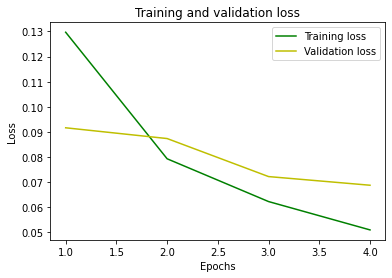

In [28]:
plt.clf()
loss = history_2.history['loss']
val_loss = history_2.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'y', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

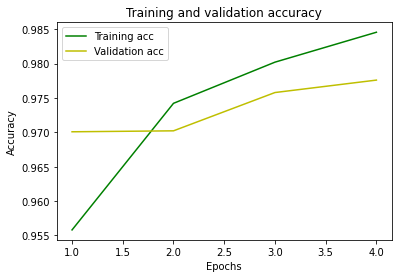

In [29]:
plt.clf()
acc = history_2.history['accuracy']
val_acc = history_2.history['val_accuracy']
plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'y', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

CONFUSION MATRIX

In [30]:
from sklearn.metrics import confusion_matrix

In [31]:
predicted= model.predict(x_test)

In [32]:
predicted= np.round(predicted).astype(int)

In [33]:
sum(predicted)

array([4648])

In [34]:
confusion_matrix(y_test,predicted)

array([[4193,   91],
       [ 139, 4557]])

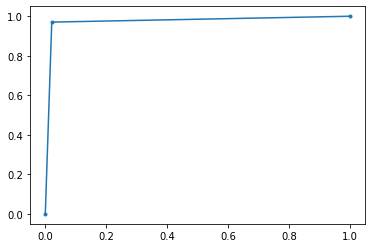

In [35]:
from sklearn.metrics import roc_curve,auc

nn_fpr_keras, nn_tpr_keras, nn_thresholds_keras = roc_curve(y_test, predicted)
auc_keras = auc(nn_fpr_keras, nn_tpr_keras)
plt.plot(nn_fpr_keras, nn_tpr_keras, marker='.', label='Neural Network (auc = %0.3f)' % auc_keras)

Testing our model on a fake news

In [36]:
fake_news = "Elon Musk reportedly dead at 49 following Tesla Battery Malfunction"

In [41]:
fake_news= clean_text(fake_news)
fake_news = process_text([[fake_news]],tokenizer)

In [42]:
prediction = model.predict(fake_news)

In [43]:
 np.round(prediction).astype(int)

array([[1]])